<a href="https://colab.research.google.com/github/wayoo2019/Summer-Projects/blob/master/IEEE_4_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 5. Model Tuning

In [ ]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#models
import xgboost as xgb
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

import time
import warnings
import gc


import datetime

pd.set_option('display.max_columns', None)
# plt.style.use(style = 'seaborn')

warnings.filterwarnings('ignore')

In [ ]:
# mount Google Drive to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load data from part 1

In [ ]:
%%time
train = pd.read_parquet("drive/My Drive/ieee-fraud-detection/train.parquet.gzip")
test = pd.read_parquet("drive/My Drive/ieee-fraud-detection/test.parquet.gzip")

CPU times: user 12.5 s, sys: 3.87 s, total: 16.3 s
Wall time: 15.9 s


### 5.1 Feature Enginnering according to Part 4


Convert delta time to date time and extract Hour, Day, and weekday

In [ ]:
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
train['TransactionDT'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test['TransactionDT'] = test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

train["Hour"] = train["TransactionDT"].dt.hour
train["Day"] = train["TransactionDT"].dt.day
train["Weekday"] = train["TransactionDT"].dt.weekday

test["Hour"] = test["TransactionDT"].dt.hour
test["Day"] = test["TransactionDT"].dt.day
test["Weekday"] = test["TransactionDT"].dt.weekday

Extract email domain from email address

In [ ]:
train['P_Email'] = train['P_emaildomain'].str.split(".", expand=True)[0]
train['R_Email'] = train['R_emaildomain'].str.split(".", expand=True)[0]

test['P_Email'] = test['P_emaildomain'].str.split(".", expand=True)[0]
test['R_Email'] = test['R_emaildomain'].str.split(".", expand=True)[0]

Extract transaction amount decimal and decimal length

In [ ]:
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

train['TransactionAmt_decimal_lenght'] = train['TransactionAmt'].astype(str).str.split('.', expand=True)[1].str.len()
test['TransactionAmt_decimal_lenght'] = test['TransactionAmt'].astype(str).str.split('.', expand=True)[1].str.len()

Add missing count per row (per sample)

In [ ]:
train['mis_count'] = train.isnull().sum(axis=1)
test['mis_count'] = test.isnull().sum(axis=1)

Extract first date of transaction 

In [ ]:
train['diff_days_from_first_transaction'] = train['D1'].fillna(0).apply(lambda x: (datetime.timedelta(days = x)))
train['client_firstdate'] = (train['TransactionDT'] - train['diff_days_from_first_transaction']).apply(lambda x:str(x.date()))

test['diff_days_from_first_transaction'] = test['D1'].fillna(0).apply(lambda x: (datetime.timedelta(days = x)))
test['client_firstdate'] = (test['TransactionDT'] - test['diff_days_from_first_transaction']).apply(lambda x:str(x.date()))

train[['TransactionDT', 'D1', 'diff_days_from_first_transaction', 'client_firstdate']].head()

,TransactionDT,D1,diff_days_from_first_transaction,client_firstdate
0,2017-12-02 00:00:00,14.0,14 days,2017-11-18
1,2017-12-02 00:00:01,0.0,0 days,2017-12-02
2,2017-12-02 00:01:09,0.0,0 days,2017-12-02
3,2017-12-02 00:01:39,112.0,112 days,2017-08-12
4,2017-12-02 00:01:46,0.0,0 days,2017-12-02


In [ ]:
train = train.drop(columns='diff_days_from_first_transaction')
test = test.drop(columns='diff_days_from_first_transaction')

In [ ]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')

# LABEL ENCODE
def encode_LE(col,train=train,test=test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')

# COMBINE FEATURES
def encode_CB(col1,col2,df1=train,df2=test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')



Add frequency of feature

In [ ]:
encode_FE(train, test,['addr1','card1','card2','card3','P_Email', 'R_Email'])

addr1_FE , card1_FE , card2_FE , card3_FE , P_Email_FE , R_Email_FE , 

Combine features

In [ ]:
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_Email')

card1_addr1 , card1_addr1_P_Email , 

In [ ]:
# FREQUENCY ENOCDE
encode_FE(train, test,['card1_addr1','card1_addr1_P_Email'])

card1_addr1_FE , card1_addr1_P_Email_FE , 

Aggregate features

In [ ]:
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=train, test_df=test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')

In [ ]:
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_Email'],['mean','std'],usena=True)


'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_Email_mean' , 'TransactionAmt_card1_addr1_P_Email_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_Email_mean' , 'D9_card1_addr1_P_Email_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_Email_mean' , 'D11_card1_addr1_P_Email_std' , 

### 5.2 Top 30 features

In [ ]:
fs_30 = ['C1', 'card1', 'V315', 'D10', 'C6', 'V313', 'V127', 'C13', 'D15', 'C11', 'C14', 'V307', 'V310', 'V130', 'addr1', 'TransactionID', 'TransactionAmt', 'V308', 'C2', 'card2', 'V317', 'D1', 'C9', 'card5', 'V312', 'R_emaildomain','TransactionDT', 'V314']
fs_30.remove('TransactionDT')
fs_30.remove('TransactionID')
fs_30.extend(['TransactionAmt_decimal', 'P_Email', 'R_Email', 'Hour', 'Day', 'Weekday', 'mis_count','card1_addr1', 'card1_addr1_P_Email','card1_addr1_FE' , 'card1_addr1_P_Email_FE', 'addr1_FE' , 'card1_FE' , 'card2_FE' , 'card3_FE' , 'P_Email_FE' , 'R_Email_FE'])
fs_30.append('mis_count')
print(fs_30)

['C1', 'card1', 'V315', 'D10', 'C6', 'V313', 'V127', 'C13', 'D15', 'C11', 'C14', 'V307', 'V310', 'V130', 'addr1', 'TransactionAmt', 'V308', 'C2', 'card2', 'V317', 'D1', 'C9', 'card5', 'V312', 'R_emaildomain', 'V314', 'TransactionAmt_decimal', 'P_Email', 'R_Email', 'Hour', 'Day', 'Weekday', 'mis_count', 'card1_addr1', 'card1_addr1_P_Email', 'card1_addr1_FE', 'card1_addr1_P_Email_FE', 'addr1_FE', 'card1_FE', 'card2_FE', 'card3_FE', 'P_Email_FE', 'R_Email_FE', 'mis_count']


In [ ]:
len(fs_30)

44

Encode Categorical features

In [ ]:
for col in train[fs_30]:
  if train[col].dtype == 'object':
    le = LabelEncoder()
    le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
    train[col] = le.transform(list(train[col].astype(str).values))
    test[col] = le.transform(list(test[col].astype(str).values))

In [ ]:
X = train[fs_30]
y = train['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.9241598400358766


In [ ]:
X = train[fs_30]
y = train['isFraud']
clf = lgb.LGBMClassifier()

cross_val_score(clf, X, y, cv=5, scoring='roc_auc').mean()


0.8960173931654731

In [ ]:
del X, y, X_train, X_test, y_train, y_test, clf

The default LGBM parameter achieves ROC_AUC around 0.9

Use Top 100 features

In [ ]:
rfe_importance = pd.read_csv('/content/drive/MyDrive/ieee-fraud-detection/rfe_importance.csv')
rfe_importance

,Unnamed: 0,Features,Score
0,0,TransactionID,2011
1,1,TransactionDT,979
2,2,TransactionAmt,1899
3,3,ProductCD,215
4,4,card1,1630
...,...,...,...
316,316,id_36,26
317,317,id_37,36
318,318,id_38,77
319,319,DeviceType,193


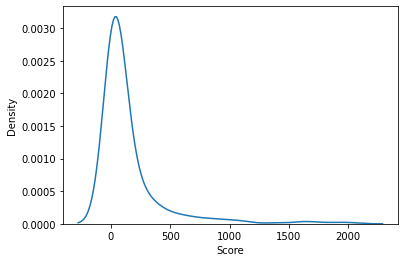

In [ ]:
sns.kdeplot(rfe_importance['Score'])

Add FE new features to original 98 features 

In [ ]:
fs_98 = rfe_importance[rfe_importance['Score']>100]['Features'].tolist()
fs_98.remove('TransactionDT')
fs_98.remove('TransactionID')
fs_98.extend(['TransactionAmt_decimal', 'P_Email', 'R_Email', 'Hour', 'Day', 'Weekday', 'mis_count','card1_addr1', 'card1_addr1_P_Email','card1_addr1_FE' , 'card1_addr1_P_Email_FE','addr1_FE' , 'card1_FE' , 'card2_FE' , 'card3_FE' , 'P_Email_FE' , 'R_Email_FE'])
fs_98.extend(['TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_Email_mean' , 'TransactionAmt_card1_addr1_P_Email_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_Email_mean' , 'D9_card1_addr1_P_Email_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_Email_mean' , 'D11_card1_addr1_P_Email_std' ])
# fs_98.append('mis_count')
print(fs_98)

['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D15', 'M2', 'M3', 'M4', 'M5', 'M6', 'M9', 'V5', 'V12', 'V13', 'V20', 'V35', 'V36', 'V38', 'V45', 'V53', 'V54', 'V56', 'V61', 'V62', 'V75', 'V76', 'V78', 'V82', 'V83', 'V87', 'V96', 'V99', 'V126', 'V127', 'V128', 'V130', 'V131', 'V280', 'V282', 'V283', 'V285', 'V291', 'V294', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'id_01', 'id_02', 'id_05', 'id_06', 'id_13', 'id_14', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_33', 'DeviceType', 'DeviceInfo', 'TransactionAmt_decimal', 'P_Email', 'R_Email', 'Hour', 'Day', 'Weekday', 'mis_count', 'card1_addr1', 'card1_addr1_P_Email', 'card1_addr1_FE', 'card1_addr1_P_Email_FE', 'addr1_FE', 'card1_FE', 'card2_FE', 'card3_FE', 'P_Email_FE', 'R_Emai

In [ ]:
len(fs_98)

131

Categorical features encoding

In [ ]:
for col in train[fs_98]:
  if train[col].dtype == 'object':
    le = LabelEncoder()
    le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
    train[col] = le.transform(list(train[col].astype(str).values))
    test[col] = le.transform(list(test[col].astype(str).values)) 

####5.3 Hyperparameter Tunning

In [ ]:
!pip install optuna

In [ ]:

import optuna  # pip install optuna

In [ ]:
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        # "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 1000, step=20),
        "max_depth": trial.suggest_int("max_depth", -1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200, step=20),
        "lambda_l1": trial.suggest_loguniform("lambda_l1",1e-3, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-3, 10.0),
        # "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1, step=0.05),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1, step=0.05),
        "min_sum_hessian_in_leaf": trial.suggest_loguniform("min_sum_hessian_in_leaf",1e-3, 20.0),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]


        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="auc",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "auc")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    return np.mean(cv_scores)

In [ ]:
%%time
X = train[fs_98]
y = train['isFraud']
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=50)

[I 2021-10-10 13:54:41,793] A new study created in memory with name: LGBM Classifier


[1]	valid_0's auc: 0.836315	valid_0's binary_logloss: 0.134858
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.857766	valid_0's binary_logloss: 0.128175
[3]	valid_0's auc: 0.866013	valid_0's binary_logloss: 0.123421
[4]	valid_0's auc: 0.870719	valid_0's binary_logloss: 0.11967
[5]	valid_0's auc: 0.872972	valid_0's binary_logloss: 0.116438
[6]	valid_0's auc: 0.875012	valid_0's binary_logloss: 0.113685
[7]	valid_0's auc: 0.880637	valid_0's binary_logloss: 0.1113
[8]	valid_0's auc: 0.88296	valid_0's binary_logloss: 0.108998
[9]	valid_0's auc: 0.884135	valid_0's binary_logloss: 0.107147
[10]	valid_0's auc: 0.885584	valid_0's binary_logloss: 0.105358
[11]	valid_0's auc: 0.887079	valid_0's binary_logloss: 0.103723
[12]	valid_0's auc: 0.888243	valid_0's binary_logloss: 0.102233
[13]	valid_0's auc: 0.889184	valid_0's binary_logloss: 0.10097
[14]	valid_0's auc: 0.890778	valid_0's binary_logloss: 0.0997519
[15]	valid_0's auc: 0.891184	valid_0's binary_logloss:

[I 2021-10-10 13:57:44,269] Trial 0 finished with value: 0.9305607083264933 and parameters: {'learning_rate': 0.07320787849101149, 'num_leaves': 220, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.6398425520548006, 'lambda_l2': 0.43584190723439215, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 7, 'feature_fraction': 0.8, 'min_sum_hessian_in_leaf': 3.1396208987650716}. Best is trial 0 with value: 0.9305607083264933.


[1]	valid_0's auc: 0.817867	valid_0's binary_logloss: 0.139084
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.855094	valid_0's binary_logloss: 0.132777
[3]	valid_0's auc: 0.864147	valid_0's binary_logloss: 0.127731
[4]	valid_0's auc: 0.870797	valid_0's binary_logloss: 0.123986
[5]	valid_0's auc: 0.874536	valid_0's binary_logloss: 0.120819
[6]	valid_0's auc: 0.876011	valid_0's binary_logloss: 0.117989
[7]	valid_0's auc: 0.879751	valid_0's binary_logloss: 0.115452
[8]	valid_0's auc: 0.882455	valid_0's binary_logloss: 0.113256
[9]	valid_0's auc: 0.883694	valid_0's binary_logloss: 0.111392
[10]	valid_0's auc: 0.884895	valid_0's binary_logloss: 0.109713
[11]	valid_0's auc: 0.885405	valid_0's binary_logloss: 0.108142
[12]	valid_0's auc: 0.886154	valid_0's binary_logloss: 0.106717
[13]	valid_0's auc: 0.888659	valid_0's binary_logloss: 0.105149
[14]	valid_0's auc: 0.889812	valid_0's binary_logloss: 0.103736
[15]	valid_0's auc: 0.891189	valid_0's binary_logl

[I 2021-10-10 14:01:06,291] Trial 1 finished with value: 0.9360155250344784 and parameters: {'learning_rate': 0.04622475949007913, 'num_leaves': 840, 'max_depth': 8, 'min_data_in_leaf': 20, 'lambda_l1': 0.0011572688937757536, 'lambda_l2': 0.1467076489573795, 'bagging_fraction': 0.55, 'bagging_freq': 6, 'feature_fraction': 1.0, 'min_sum_hessian_in_leaf': 0.004675594500567097}. Best is trial 1 with value: 0.9360155250344784.


[1]	valid_0's auc: 0.837614	valid_0's binary_logloss: 0.127661
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.867885	valid_0's binary_logloss: 0.120351
[3]	valid_0's auc: 0.877211	valid_0's binary_logloss: 0.115941
[4]	valid_0's auc: 0.880536	valid_0's binary_logloss: 0.111926
[5]	valid_0's auc: 0.885839	valid_0's binary_logloss: 0.108384
[6]	valid_0's auc: 0.88966	valid_0's binary_logloss: 0.105223
[7]	valid_0's auc: 0.892852	valid_0's binary_logloss: 0.102497
[8]	valid_0's auc: 0.894163	valid_0's binary_logloss: 0.100194
[9]	valid_0's auc: 0.896787	valid_0's binary_logloss: 0.0980833
[10]	valid_0's auc: 0.899517	valid_0's binary_logloss: 0.0963335
[11]	valid_0's auc: 0.901131	valid_0's binary_logloss: 0.094719
[12]	valid_0's auc: 0.902321	valid_0's binary_logloss: 0.0933288
[13]	valid_0's auc: 0.904173	valid_0's binary_logloss: 0.0919724
[14]	valid_0's auc: 0.905318	valid_0's binary_logloss: 0.0908503
[15]	valid_0's auc: 0.90741	valid_0's binary_l

[I 2021-10-10 14:03:59,075] Trial 2 finished with value: 0.9476416666076674 and parameters: {'learning_rate': 0.0972489745643429, 'num_leaves': 820, 'max_depth': 8, 'min_data_in_leaf': 80, 'lambda_l1': 0.04161544661281455, 'lambda_l2': 0.0010956328328440533, 'bagging_fraction': 0.8, 'bagging_freq': 4, 'feature_fraction': 0.6000000000000001, 'min_sum_hessian_in_leaf': 0.9079760388272884}. Best is trial 2 with value: 0.9476416666076674.


[1]	valid_0's auc: 0.873577	valid_0's binary_logloss: 0.140915
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.887141	valid_0's binary_logloss: 0.134957
[3]	valid_0's auc: 0.891418	valid_0's binary_logloss: 0.13065
[4]	valid_0's auc: 0.895685	valid_0's binary_logloss: 0.126573
[5]	valid_0's auc: 0.897699	valid_0's binary_logloss: 0.123313
[6]	valid_0's auc: 0.899868	valid_0's binary_logloss: 0.120352
[7]	valid_0's auc: 0.902298	valid_0's binary_logloss: 0.117554
[8]	valid_0's auc: 0.902747	valid_0's binary_logloss: 0.115096
[9]	valid_0's auc: 0.904069	valid_0's binary_logloss: 0.113095
[10]	valid_0's auc: 0.905324	valid_0's binary_logloss: 0.111166
[11]	valid_0's auc: 0.906566	valid_0's binary_logloss: 0.109302
[12]	valid_0's auc: 0.907409	valid_0's binary_logloss: 0.107563
[13]	valid_0's auc: 0.908247	valid_0's binary_logloss: 0.105897
[14]	valid_0's auc: 0.908959	valid_0's binary_logloss: 0.104414
[15]	valid_0's auc: 0.909481	valid_0's binary_loglo

[I 2021-10-10 14:08:14,856] Trial 3 finished with value: 0.9497872390142981 and parameters: {'learning_rate': 0.047670956248094684, 'num_leaves': 740, 'max_depth': 0, 'min_data_in_leaf': 120, 'lambda_l1': 2.8642358859686463, 'lambda_l2': 5.061063685882238, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 5, 'feature_fraction': 0.5, 'min_sum_hessian_in_leaf': 0.0025229659952614833}. Best is trial 3 with value: 0.9497872390142981.


[1]	valid_0's auc: 0.634576	valid_0's binary_logloss: 0.146939
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.708806	valid_0's binary_logloss: 0.143095
[3]	valid_0's auc: 0.779513	valid_0's binary_logloss: 0.140466
[4]	valid_0's auc: 0.782756	valid_0's binary_logloss: 0.13825
[5]	valid_0's auc: 0.794891	valid_0's binary_logloss: 0.13648
[6]	valid_0's auc: 0.804444	valid_0's binary_logloss: 0.134735
[7]	valid_0's auc: 0.808253	valid_0's binary_logloss: 0.13304
[8]	valid_0's auc: 0.808815	valid_0's binary_logloss: 0.131683
[9]	valid_0's auc: 0.81527	valid_0's binary_logloss: 0.130285
[10]	valid_0's auc: 0.813245	valid_0's binary_logloss: 0.129215
[11]	valid_0's auc: 0.815168	valid_0's binary_logloss: 0.128216
[12]	valid_0's auc: 0.815794	valid_0's binary_logloss: 0.127164
[13]	valid_0's auc: 0.823837	valid_0's binary_logloss: 0.126036
[14]	valid_0's auc: 0.823532	valid_0's binary_logloss: 0.125065
[15]	valid_0's auc: 0.824085	valid_0's binary_logloss:

[I 2021-10-10 14:09:43,769] Trial 4 finished with value: 0.8660929166113764 and parameters: {'learning_rate': 0.05097290952952112, 'num_leaves': 600, 'max_depth': 2, 'min_data_in_leaf': 160, 'lambda_l1': 0.17854307325953342, 'lambda_l2': 0.19841515221954173, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.75, 'min_sum_hessian_in_leaf': 0.0019523985953547231}. Best is trial 3 with value: 0.9497872390142981.


[1]	valid_0's auc: 0.838674	valid_0's binary_logloss: 0.149231
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.860081	valid_0's binary_logloss: 0.147058


[I 2021-10-10 14:09:48,854] Trial 5 pruned. Trial was pruned at iteration 2.


[1]	valid_0's auc: 0.878833	valid_0's binary_logloss: 0.142242
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.890834	valid_0's binary_logloss: 0.136563
[3]	valid_0's auc: 0.895676	valid_0's binary_logloss: 0.13216
[4]	valid_0's auc: 0.899028	valid_0's binary_logloss: 0.128522
[5]	valid_0's auc: 0.900723	valid_0's binary_logloss: 0.12539
[6]	valid_0's auc: 0.903491	valid_0's binary_logloss: 0.12254
[7]	valid_0's auc: 0.905978	valid_0's binary_logloss: 0.120046
[8]	valid_0's auc: 0.907089	valid_0's binary_logloss: 0.117812
[9]	valid_0's auc: 0.90804	valid_0's binary_logloss: 0.115836
[10]	valid_0's auc: 0.908766	valid_0's binary_logloss: 0.114021
[11]	valid_0's auc: 0.909628	valid_0's binary_logloss: 0.112315
[12]	valid_0's auc: 0.910344	valid_0's binary_logloss: 0.110685
[13]	valid_0's auc: 0.910849	valid_0's binary_logloss: 0.10922
[14]	valid_0's auc: 0.911657	valid_0's binary_logloss: 0.107728
[15]	valid_0's auc: 0.912387	valid_0's binary_logloss: 

[I 2021-10-10 14:15:33,657] Trial 6 finished with value: 0.9501884400834244 and parameters: {'learning_rate': 0.038259582623172264, 'num_leaves': 540, 'max_depth': -1, 'min_data_in_leaf': 200, 'lambda_l1': 0.0077689490575555895, 'lambda_l2': 1.993728590510824, 'bagging_fraction': 0.55, 'bagging_freq': 5, 'feature_fraction': 0.9500000000000001, 'min_sum_hessian_in_leaf': 0.26149477990822256}. Best is trial 6 with value: 0.9501884400834244.


[1]	valid_0's auc: 0.875589	valid_0's binary_logloss: 0.130147
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.895027	valid_0's binary_logloss: 0.122705
[3]	valid_0's auc: 0.90381	valid_0's binary_logloss: 0.117279
[4]	valid_0's auc: 0.909763	valid_0's binary_logloss: 0.112529
[5]	valid_0's auc: 0.912045	valid_0's binary_logloss: 0.108926
[6]	valid_0's auc: 0.915052	valid_0's binary_logloss: 0.105444
[7]	valid_0's auc: 0.916899	valid_0's binary_logloss: 0.102431
[8]	valid_0's auc: 0.918915	valid_0's binary_logloss: 0.0997505
[9]	valid_0's auc: 0.919917	valid_0's binary_logloss: 0.0977283
[10]	valid_0's auc: 0.921306	valid_0's binary_logloss: 0.0956349
[11]	valid_0's auc: 0.92264	valid_0's binary_logloss: 0.0936907
[12]	valid_0's auc: 0.923616	valid_0's binary_logloss: 0.0919474
[13]	valid_0's auc: 0.926127	valid_0's binary_logloss: 0.0901421
[14]	valid_0's auc: 0.926725	valid_0's binary_logloss: 0.0887161
[15]	valid_0's auc: 0.927601	valid_0's binary

[I 2021-10-10 14:21:42,115] Trial 7 finished with value: 0.9680647086268135 and parameters: {'learning_rate': 0.0756816519463245, 'num_leaves': 520, 'max_depth': -1, 'min_data_in_leaf': 160, 'lambda_l1': 0.5765200910987622, 'lambda_l2': 0.0018637306884949092, 'bagging_fraction': 0.9, 'bagging_freq': 2, 'feature_fraction': 0.55, 'min_sum_hessian_in_leaf': 0.18538347310538988}. Best is trial 7 with value: 0.9680647086268135.
[I 2021-10-10 14:21:46,438] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2021-10-10 14:21:50,873] Trial 9 pruned. Trial was pruned at iteration 0.
[I 2021-10-10 14:21:55,531] Trial 10 pruned. Trial was pruned at iteration 0.


[1]	valid_0's auc: 0.86948	valid_0's binary_logloss: 0.136806
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.877425	valid_0's binary_logloss: 0.129463
[3]	valid_0's auc: 0.890269	valid_0's binary_logloss: 0.123905
[4]	valid_0's auc: 0.891956	valid_0's binary_logloss: 0.119695
[5]	valid_0's auc: 0.895799	valid_0's binary_logloss: 0.115928
[6]	valid_0's auc: 0.898169	valid_0's binary_logloss: 0.112688
[7]	valid_0's auc: 0.900539	valid_0's binary_logloss: 0.109991
[8]	valid_0's auc: 0.902269	valid_0's binary_logloss: 0.107556
[9]	valid_0's auc: 0.903437	valid_0's binary_logloss: 0.105385
[10]	valid_0's auc: 0.905118	valid_0's binary_logloss: 0.103471
[11]	valid_0's auc: 0.906605	valid_0's binary_logloss: 0.101666
[12]	valid_0's auc: 0.90778	valid_0's binary_logloss: 0.100042
[13]	valid_0's auc: 0.909558	valid_0's binary_logloss: 0.0984813
[14]	valid_0's auc: 0.910554	valid_0's binary_logloss: 0.0971199
[15]	valid_0's auc: 0.912665	valid_0's binary_logl

[I 2021-10-10 14:26:36,468] Trial 11 finished with value: 0.956956089281063 and parameters: {'learning_rate': 0.07423605609841091, 'num_leaves': 500, 'max_depth': -1, 'min_data_in_leaf': 160, 'lambda_l1': 0.054377912265798925, 'lambda_l2': 4.19520771862288, 'bagging_fraction': 0.4, 'bagging_freq': 2, 'feature_fraction': 0.9500000000000001, 'min_sum_hessian_in_leaf': 0.3531227852618894}. Best is trial 7 with value: 0.9680647086268135.
[I 2021-10-10 14:26:40,644] Trial 12 pruned. Trial was pruned at iteration 0.


[1]	valid_0's auc: 0.871057	valid_0's binary_logloss: 0.129383
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.886453	valid_0's binary_logloss: 0.122505
[3]	valid_0's auc: 0.898558	valid_0's binary_logloss: 0.116805
[4]	valid_0's auc: 0.902424	valid_0's binary_logloss: 0.112554
[5]	valid_0's auc: 0.905835	valid_0's binary_logloss: 0.108852
[6]	valid_0's auc: 0.908984	valid_0's binary_logloss: 0.105566
[7]	valid_0's auc: 0.911713	valid_0's binary_logloss: 0.102618
[8]	valid_0's auc: 0.913622	valid_0's binary_logloss: 0.100113
[9]	valid_0's auc: 0.914679	valid_0's binary_logloss: 0.0980921
[10]	valid_0's auc: 0.915752	valid_0's binary_logloss: 0.0960192
[11]	valid_0's auc: 0.917507	valid_0's binary_logloss: 0.0942044
[12]	valid_0's auc: 0.91866	valid_0's binary_logloss: 0.0925701
[13]	valid_0's auc: 0.92039	valid_0's binary_logloss: 0.0909402
[14]	valid_0's auc: 0.921617	valid_0's binary_logloss: 0.0895507
[15]	valid_0's auc: 0.922538	valid_0's binary_

[I 2021-10-10 14:32:27,263] Trial 13 finished with value: 0.9635463767638187 and parameters: {'learning_rate': 0.08997154444453023, 'num_leaves': 660, 'max_depth': -1, 'min_data_in_leaf': 160, 'lambda_l1': 0.039013205214620476, 'lambda_l2': 0.8092894592992866, 'bagging_fraction': 0.45, 'bagging_freq': 2, 'feature_fraction': 0.9, 'min_sum_hessian_in_leaf': 0.023426296758310334}. Best is trial 7 with value: 0.9680647086268135.
[I 2021-10-10 14:32:32,737] Trial 14 pruned. Trial was pruned at iteration 0.
[I 2021-10-10 14:32:37,556] Trial 15 pruned. Trial was pruned at iteration 0.
[I 2021-10-10 14:32:42,524] Trial 16 pruned. Trial was pruned at iteration 0.
[I 2021-10-10 14:32:47,771] Trial 17 pruned. Trial was pruned at iteration 0.
[I 2021-10-10 14:32:52,182] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2021-10-10 14:32:56,532] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2021-10-10 14:33:00,972] Trial 20 pruned. Trial was pruned at iteration 0.


[1]	valid_0's auc: 0.871553	valid_0's binary_logloss: 0.134437
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.888477	valid_0's binary_logloss: 0.12727
[3]	valid_0's auc: 0.895764	valid_0's binary_logloss: 0.121773
[4]	valid_0's auc: 0.898637	valid_0's binary_logloss: 0.117456
[5]	valid_0's auc: 0.901578	valid_0's binary_logloss: 0.113654
[6]	valid_0's auc: 0.90343	valid_0's binary_logloss: 0.11047
[7]	valid_0's auc: 0.906258	valid_0's binary_logloss: 0.107677
[8]	valid_0's auc: 0.907108	valid_0's binary_logloss: 0.10533
[9]	valid_0's auc: 0.908262	valid_0's binary_logloss: 0.103214
[10]	valid_0's auc: 0.908673	valid_0's binary_logloss: 0.101328
[11]	valid_0's auc: 0.910001	valid_0's binary_logloss: 0.0994421
[12]	valid_0's auc: 0.911128	valid_0's binary_logloss: 0.0977981
[13]	valid_0's auc: 0.912666	valid_0's binary_logloss: 0.0962282
[14]	valid_0's auc: 0.914001	valid_0's binary_logloss: 0.0948084
[15]	valid_0's auc: 0.915504	valid_0's binary_logl

[I 2021-10-10 14:37:53,343] Trial 21 finished with value: 0.9587995098333275 and parameters: {'learning_rate': 0.07885229142631442, 'num_leaves': 460, 'max_depth': -1, 'min_data_in_leaf': 160, 'lambda_l1': 0.037476163558490636, 'lambda_l2': 2.9266684932985054, 'bagging_fraction': 0.4, 'bagging_freq': 2, 'feature_fraction': 1.0, 'min_sum_hessian_in_leaf': 0.34643212996925676}. Best is trial 7 with value: 0.9680647086268135.


[1]	valid_0's auc: 0.871015	valid_0's binary_logloss: 0.133957
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.887939	valid_0's binary_logloss: 0.126805
[3]	valid_0's auc: 0.893256	valid_0's binary_logloss: 0.121487
[4]	valid_0's auc: 0.898287	valid_0's binary_logloss: 0.116933
[5]	valid_0's auc: 0.900361	valid_0's binary_logloss: 0.113336
[6]	valid_0's auc: 0.902514	valid_0's binary_logloss: 0.110165
[7]	valid_0's auc: 0.90573	valid_0's binary_logloss: 0.107381
[8]	valid_0's auc: 0.907442	valid_0's binary_logloss: 0.104953
[9]	valid_0's auc: 0.909165	valid_0's binary_logloss: 0.102686
[10]	valid_0's auc: 0.911271	valid_0's binary_logloss: 0.100766
[11]	valid_0's auc: 0.913167	valid_0's binary_logloss: 0.0990257
[12]	valid_0's auc: 0.914108	valid_0's binary_logloss: 0.0974793
[13]	valid_0's auc: 0.915538	valid_0's binary_logloss: 0.0959134
[14]	valid_0's auc: 0.91655	valid_0's binary_logloss: 0.0945469
[15]	valid_0's auc: 0.917435	valid_0's binary_lo

[I 2021-10-10 14:42:51,216] Trial 22 finished with value: 0.9589036742907376 and parameters: {'learning_rate': 0.08000270262532731, 'num_leaves': 440, 'max_depth': 0, 'min_data_in_leaf': 160, 'lambda_l1': 0.02575894202361051, 'lambda_l2': 2.66191347032078, 'bagging_fraction': 0.4, 'bagging_freq': 3, 'feature_fraction': 1.0, 'min_sum_hessian_in_leaf': 0.887800377207859}. Best is trial 7 with value: 0.9680647086268135.
[I 2021-10-10 14:42:56,464] Trial 23 pruned. Trial was pruned at iteration 0.
[I 2021-10-10 14:43:01,199] Trial 24 pruned. Trial was pruned at iteration 0.


[1]	valid_0's auc: 0.877781	valid_0's binary_logloss: 0.137187
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.890274	valid_0's binary_logloss: 0.130053
[3]	valid_0's auc: 0.896794	valid_0's binary_logloss: 0.124586
[4]	valid_0's auc: 0.900075	valid_0's binary_logloss: 0.120296
[5]	valid_0's auc: 0.901752	valid_0's binary_logloss: 0.116698
[6]	valid_0's auc: 0.905024	valid_0's binary_logloss: 0.113409
[7]	valid_0's auc: 0.907244	valid_0's binary_logloss: 0.110515
[8]	valid_0's auc: 0.908863	valid_0's binary_logloss: 0.107959
[9]	valid_0's auc: 0.910688	valid_0's binary_logloss: 0.105631
[10]	valid_0's auc: 0.913093	valid_0's binary_logloss: 0.103465
[11]	valid_0's auc: 0.914063	valid_0's binary_logloss: 0.101627
[12]	valid_0's auc: 0.915002	valid_0's binary_logloss: 0.0998691
[13]	valid_0's auc: 0.915945	valid_0's binary_logloss: 0.0981297
[14]	valid_0's auc: 0.916603	valid_0's binary_logloss: 0.096604
[15]	valid_0's auc: 0.917392	valid_0's binary_lo

[I 2021-10-10 14:48:56,951] Trial 25 finished with value: 0.9603105266992079 and parameters: {'learning_rate': 0.06691232661476583, 'num_leaves': 560, 'max_depth': 0, 'min_data_in_leaf': 120, 'lambda_l1': 0.019856246302186766, 'lambda_l2': 6.568381018510522, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 3, 'feature_fraction': 0.9, 'min_sum_hessian_in_leaf': 0.04733444605955729}. Best is trial 7 with value: 0.9680647086268135.
[I 2021-10-10 14:49:01,249] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2021-10-10 14:49:05,800] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2021-10-10 14:49:10,667] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2021-10-10 14:49:15,536] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2021-10-10 14:49:20,234] Trial 30 pruned. Trial was pruned at iteration 0.


[1]	valid_0's auc: 0.87456	valid_0's binary_logloss: 0.133239
Training until validation scores don't improve for 100 rounds.


[I 2021-10-10 14:49:25,395] Trial 31 pruned. Trial was pruned at iteration 1.


[1]	valid_0's auc: 0.874779	valid_0's binary_logloss: 0.133938
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.890504	valid_0's binary_logloss: 0.126614
[3]	valid_0's auc: 0.89945	valid_0's binary_logloss: 0.120832
[4]	valid_0's auc: 0.901725	valid_0's binary_logloss: 0.116381
[5]	valid_0's auc: 0.905346	valid_0's binary_logloss: 0.112427
[6]	valid_0's auc: 0.907458	valid_0's binary_logloss: 0.109052
[7]	valid_0's auc: 0.909189	valid_0's binary_logloss: 0.106238
[8]	valid_0's auc: 0.910559	valid_0's binary_logloss: 0.103687
[9]	valid_0's auc: 0.911184	valid_0's binary_logloss: 0.101545
[10]	valid_0's auc: 0.912303	valid_0's binary_logloss: 0.099492
[11]	valid_0's auc: 0.914131	valid_0's binary_logloss: 0.0976221
[12]	valid_0's auc: 0.915456	valid_0's binary_logloss: 0.0959324
[13]	valid_0's auc: 0.91705	valid_0's binary_logloss: 0.0942944
[14]	valid_0's auc: 0.918729	valid_0's binary_logloss: 0.0928039
[15]	valid_0's auc: 0.919383	valid_0's binary_lo

[I 2021-10-10 14:55:32,004] Trial 32 finished with value: 0.9622599307785631 and parameters: {'learning_rate': 0.07989465749765821, 'num_leaves': 640, 'max_depth': 0, 'min_data_in_leaf': 140, 'lambda_l1': 0.023226843595590563, 'lambda_l2': 4.027857067116253, 'bagging_fraction': 0.5, 'bagging_freq': 2, 'feature_fraction': 1.0, 'min_sum_hessian_in_leaf': 0.5749716595812838}. Best is trial 7 with value: 0.9680647086268135.


[1]	valid_0's auc: 0.872908	valid_0's binary_logloss: 0.139972
Training until validation scores don't improve for 100 rounds.


[I 2021-10-10 14:55:37,250] Trial 33 pruned. Trial was pruned at iteration 1.
[I 2021-10-10 14:55:41,767] Trial 34 pruned. Trial was pruned at iteration 0.
[I 2021-10-10 14:55:46,256] Trial 35 pruned. Trial was pruned at iteration 0.


[1]	valid_0's auc: 0.888718	valid_0's binary_logloss: 0.131669
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.898791	valid_0's binary_logloss: 0.123965
[3]	valid_0's auc: 0.905549	valid_0's binary_logloss: 0.11799
[4]	valid_0's auc: 0.90872	valid_0's binary_logloss: 0.113292
[5]	valid_0's auc: 0.911953	valid_0's binary_logloss: 0.10926
[6]	valid_0's auc: 0.91405	valid_0's binary_logloss: 0.105695
[7]	valid_0's auc: 0.91568	valid_0's binary_logloss: 0.102527
[8]	valid_0's auc: 0.918015	valid_0's binary_logloss: 0.0995893
[9]	valid_0's auc: 0.921425	valid_0's binary_logloss: 0.0971101
[10]	valid_0's auc: 0.922494	valid_0's binary_logloss: 0.0949273
[11]	valid_0's auc: 0.923806	valid_0's binary_logloss: 0.0929493
[12]	valid_0's auc: 0.924435	valid_0's binary_logloss: 0.0911286
[13]	valid_0's auc: 0.92617	valid_0's binary_logloss: 0.0892603
[14]	valid_0's auc: 0.92738	valid_0's binary_logloss: 0.0875771
[15]	valid_0's auc: 0.928324	valid_0's binary_logl

[I 2021-10-10 15:04:26,314] Trial 36 finished with value: 0.9685144818402488 and parameters: {'learning_rate': 0.0775101261181791, 'num_leaves': 620, 'max_depth': 0, 'min_data_in_leaf': 120, 'lambda_l1': 0.06903364990186092, 'lambda_l2': 3.36201370790594, 'bagging_fraction': 1.0, 'bagging_freq': 4, 'feature_fraction': 0.9, 'min_sum_hessian_in_leaf': 0.00400857314798482}. Best is trial 36 with value: 0.9685144818402488.


[1]	valid_0's auc: 0.883246	valid_0's binary_logloss: 0.133498
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.898455	valid_0's binary_logloss: 0.126012
[3]	valid_0's auc: 0.903956	valid_0's binary_logloss: 0.120791
[4]	valid_0's auc: 0.908101	valid_0's binary_logloss: 0.116405
[5]	valid_0's auc: 0.909367	valid_0's binary_logloss: 0.112688
[6]	valid_0's auc: 0.911516	valid_0's binary_logloss: 0.109486
[7]	valid_0's auc: 0.914393	valid_0's binary_logloss: 0.106249
[8]	valid_0's auc: 0.916753	valid_0's binary_logloss: 0.103408
[9]	valid_0's auc: 0.917886	valid_0's binary_logloss: 0.101381
[10]	valid_0's auc: 0.919145	valid_0's binary_logloss: 0.0992264
[11]	valid_0's auc: 0.920739	valid_0's binary_logloss: 0.097243
[12]	valid_0's auc: 0.921846	valid_0's binary_logloss: 0.0954488
[13]	valid_0's auc: 0.923487	valid_0's binary_logloss: 0.0936711
[14]	valid_0's auc: 0.924492	valid_0's binary_logloss: 0.0921229
[15]	valid_0's auc: 0.925091	valid_0's binary_

[I 2021-10-10 15:09:52,086] Trial 37 finished with value: 0.9667053562479658 and parameters: {'learning_rate': 0.0778464769404439, 'num_leaves': 760, 'max_depth': -1, 'min_data_in_leaf': 200, 'lambda_l1': 0.08304064008805184, 'lambda_l2': 3.771858895234839, 'bagging_fraction': 1.0, 'bagging_freq': 6, 'feature_fraction': 0.45, 'min_sum_hessian_in_leaf': 0.0022834075882793774}. Best is trial 36 with value: 0.9685144818402488.


[1]	valid_0's auc: 0.878586	valid_0's binary_logloss: 0.139421
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.902554	valid_0's binary_logloss: 0.132892
[3]	valid_0's auc: 0.90865	valid_0's binary_logloss: 0.128261
[4]	valid_0's auc: 0.911677	valid_0's binary_logloss: 0.124343
[5]	valid_0's auc: 0.913937	valid_0's binary_logloss: 0.120943
[6]	valid_0's auc: 0.915593	valid_0's binary_logloss: 0.117953
[7]	valid_0's auc: 0.919249	valid_0's binary_logloss: 0.114945
[8]	valid_0's auc: 0.92162	valid_0's binary_logloss: 0.112284
[9]	valid_0's auc: 0.922261	valid_0's binary_logloss: 0.110264
[10]	valid_0's auc: 0.923643	valid_0's binary_logloss: 0.108141
[11]	valid_0's auc: 0.924781	valid_0's binary_logloss: 0.106261
[12]	valid_0's auc: 0.925478	valid_0's binary_logloss: 0.104481
[13]	valid_0's auc: 0.92665	valid_0's binary_logloss: 0.102723
[14]	valid_0's auc: 0.927408	valid_0's binary_logloss: 0.101179
[15]	valid_0's auc: 0.928127	valid_0's binary_logloss

[I 2021-10-10 15:15:31,085] Trial 38 finished with value: 0.9622906375596181 and parameters: {'learning_rate': 0.0437232720749463, 'num_leaves': 720, 'max_depth': -1, 'min_data_in_leaf': 200, 'lambda_l1': 0.20344427151316788, 'lambda_l2': 0.1558922067612191, 'bagging_fraction': 1.0, 'bagging_freq': 7, 'feature_fraction': 0.45, 'min_sum_hessian_in_leaf': 0.0031091431992142085}. Best is trial 36 with value: 0.9685144818402488.
[I 2021-10-10 15:15:35,763] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2021-10-10 15:15:40,592] Trial 40 pruned. Trial was pruned at iteration 0.


[1]	valid_0's auc: 0.879857	valid_0's binary_logloss: 0.140206
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.902822	valid_0's binary_logloss: 0.133884
[3]	valid_0's auc: 0.90905	valid_0's binary_logloss: 0.129391
[4]	valid_0's auc: 0.912417	valid_0's binary_logloss: 0.125551
[5]	valid_0's auc: 0.913859	valid_0's binary_logloss: 0.122197
[6]	valid_0's auc: 0.915415	valid_0's binary_logloss: 0.11925
[7]	valid_0's auc: 0.918542	valid_0's binary_logloss: 0.116313
[8]	valid_0's auc: 0.920025	valid_0's binary_logloss: 0.113736
[9]	valid_0's auc: 0.920787	valid_0's binary_logloss: 0.111749
[10]	valid_0's auc: 0.922062	valid_0's binary_logloss: 0.109694
[11]	valid_0's auc: 0.923473	valid_0's binary_logloss: 0.107787
[12]	valid_0's auc: 0.924398	valid_0's binary_logloss: 0.105988
[13]	valid_0's auc: 0.925495	valid_0's binary_logloss: 0.104281
[14]	valid_0's auc: 0.925454	valid_0's binary_logloss: 0.102837
[15]	valid_0's auc: 0.926348	valid_0's binary_loglos

[I 2021-10-10 15:16:12,643] Trial 41 pruned. Trial was pruned at iteration 50.


[1]	valid_0's auc: 0.883292	valid_0's binary_logloss: 0.143333
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.900099	valid_0's binary_logloss: 0.137947
[3]	valid_0's auc: 0.905671	valid_0's binary_logloss: 0.134016
[4]	valid_0's auc: 0.908924	valid_0's binary_logloss: 0.130591
[5]	valid_0's auc: 0.910058	valid_0's binary_logloss: 0.127536
[6]	valid_0's auc: 0.911098	valid_0's binary_logloss: 0.124899
[7]	valid_0's auc: 0.9132	valid_0's binary_logloss: 0.122226
[8]	valid_0's auc: 0.915112	valid_0's binary_logloss: 0.119829
[9]	valid_0's auc: 0.915788	valid_0's binary_logloss: 0.117925
[10]	valid_0's auc: 0.916536	valid_0's binary_logloss: 0.116024
[11]	valid_0's auc: 0.917509	valid_0's binary_logloss: 0.114226
[12]	valid_0's auc: 0.918448	valid_0's binary_logloss: 0.112517
[13]	valid_0's auc: 0.919821	valid_0's binary_logloss: 0.110867
[14]	valid_0's auc: 0.919946	valid_0's binary_logloss: 0.109438
[15]	valid_0's auc: 0.920773	valid_0's binary_loglos

[I 2021-10-10 15:16:28,643] Trial 42 pruned. Trial was pruned at iteration 24.


[1]	valid_0's auc: 0.878119	valid_0's binary_logloss: 0.138052
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.897768	valid_0's binary_logloss: 0.131432
[3]	valid_0's auc: 0.904787	valid_0's binary_logloss: 0.126467
[4]	valid_0's auc: 0.908019	valid_0's binary_logloss: 0.122218
[5]	valid_0's auc: 0.910456	valid_0's binary_logloss: 0.118835
[6]	valid_0's auc: 0.912967	valid_0's binary_logloss: 0.115591
[7]	valid_0's auc: 0.915154	valid_0's binary_logloss: 0.112791
[8]	valid_0's auc: 0.916676	valid_0's binary_logloss: 0.110334
[9]	valid_0's auc: 0.918766	valid_0's binary_logloss: 0.108211
[10]	valid_0's auc: 0.91987	valid_0's binary_logloss: 0.106165
[11]	valid_0's auc: 0.920772	valid_0's binary_logloss: 0.104257
[12]	valid_0's auc: 0.92147	valid_0's binary_logloss: 0.10251
[13]	valid_0's auc: 0.922661	valid_0's binary_logloss: 0.100884
[14]	valid_0's auc: 0.923416	valid_0's binary_logloss: 0.0993664
[15]	valid_0's auc: 0.924322	valid_0's binary_loglos

In [ ]:
study.best_value

0.9704445476955847

In [ ]:
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

		learning_rate: 0.07340351073358245
		num_leaves: 900
		max_depth: 0
		min_data_in_leaf: 160
		lambda_l1: 0.05119488044848822
		lambda_l2: 0.047709033969301
		bagging_fraction: 0.9500000000000001
		bagging_freq: 7
		feature_fraction: 0.6000000000000001
		min_sum_hessian_in_leaf: 0.0018725005941813233


In [ ]:
study.best_params.items()

In [ ]:
params = {
    'learning_rate': 0.07340351073358245,
		'num_leaves': 900,
		'max_depth': 0,
		'min_data_in_leaf': 160,
		'lambda_l1': 0.05119488044848822,
		'lambda_l2': 0.047709033969301,
		'bagging_fraction': 0.9500000000000001,
		'bagging_freq': 7,
		'feature_fraction': 0.6000000000000001,
		'min_sum_hessian_in_leaf': 0.0018725005941813233,
}
X = train[fs_98]
y = train['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, y_train)
cross_val_score(clf, X, y, cv=5, scoring='roc_auc').mean()

0.9289081889404409

In [ ]:
%%time
params = {
    'learning_rate': 0.07340351073358245,
		'num_leaves': 900,
		'max_depth': 0,
		'min_data_in_leaf': 160,
		'lambda_l1': 0.05119488044848822,
		'lambda_l2': 0.047709033969301,
		'bagging_fraction': 0.9500000000000001,
		'bagging_freq': 7,
		'feature_fraction': 0.6000000000000001,
		'min_sum_hessian_in_leaf': 0.0018725005941813233,
}
X = train[fs_98]
y = train['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.967120450145993
CPU times: user 2min 59s, sys: 1.85 s, total: 3min
Wall time: 1min 35s


In [ ]:
del X, y, X_train, X_test, y_train, y_test, clf

In [ ]:
params = {
    'learning_rate': 0.07340351073358245,
		'num_leaves': 900,
		'max_depth': 0,
		'min_data_in_leaf': 160,
		'lambda_l1': 0.05119488044848822,
		'lambda_l2': 0.047709033969301,
		'bagging_fraction': 0.9500000000000001,
		'bagging_freq': 7,
		'feature_fraction': 0.6000000000000001,
		'min_sum_hessian_in_leaf': 0.0018725005941813233,
}
X = train[fs_98]
y = train['isFraud']
clf = lgb.LGBMClassifier(**params)
clf.fit(X, y)

LGBMClassifier(bagging_fraction=0.9500000000000001, bagging_freq=7,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.6000000000000001, importance_type='split',
               lambda_l1=0.05119488044848822, lambda_l2=0.047709033969301,
               learning_rate=0.07340351073358245, max_depth=0,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=160, min_split_gain=0.0,
               min_sum_hessian_in_leaf=0.0018725005941813233, n_estimators=100,
               n_jobs=-1, num_leaves=900, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
sub3 = pd.DataFrame()
sub3['TransactionID'] = test['TransactionID']
sub3['isFraud'] = clf.predict_proba(test[fs_98])[:, 1] 

In [ ]:
sub3.to_csv('sub_131.csv', index=False)
!cp sub_131.csv "/content/drive/MyDrive/ieee-fraud-detection"

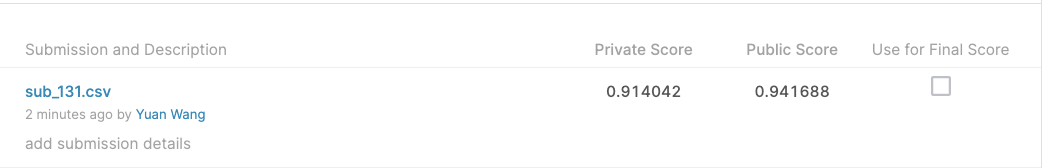

In [ ]:
0.941688*0.7+0.914042*0.3

0.9333942